# Sentiment Analysis - Amazon Reviews

Algorithm : "Decision Tree", "Logistic Regression", "SVC", "Random Forest", "Naive Bayes", "K-Neighbors"

Text vectorization - TF IDF

Notebook summary

1. Import necessary libraries

2. Import required dataset and perform baseline EDA

3. Defining the helper functions ( text preprocessing ) and executing them

4. Detailed Exploratory Data Analysis

5. Model Selection , Optimization and Evaluation


# 1. Import necessary libraries

In [79]:
# Data Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [80]:
# NLP Libraries

import string
import re
import nltk
import nltk.corpus
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [81]:
# EDA Analysis

# Text Polarity
from textblob import TextBlob

# Text Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word Cloud
from wordcloud import WordCloud

In [82]:
# Feature engineering libraries

# Label Encoding
from sklearn.preprocessing import LabelEncoder

# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Resampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# Splitting Dataset
from sklearn.model_selection import train_test_split

In [83]:
# Model Selection and Evaluation Libraries

# Model Building
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [85]:
import warnings
warnings.filterwarnings("ignore")

# 2. Import required datasets and perform baseline EDA

In [86]:
pd.set_option("display.max_colwidth", None)

In [89]:
dataset = pd.read_csv("Instruments_Reviews.csv")

In [90]:
dataset.shape

(10261, 9)

In [91]:
dataset.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]","The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]",5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]","The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. The double cloth filter blocks the pops and lets the voice through with no coloration. The metal clamp mount attaches to the mike stand secure enough to keep it attached. The goose neck needs a little coaxing to stay where you put it.",5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and prevents pops. Only thing is that the gooseneck is only marginally able to hold the screen in position and requires careful positioning of the clamp to avoid sagging.,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and performs like a studio filter. If you're recording vocals this will eliminate the pops that gets recorded when you sing.,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


Checking for null values

In [93]:
dataset.isnull().sum()

,0
reviewerID,0
asin,0
reviewerName,27
helpful,0
reviewText,7
overall,0
summary,0
unixReviewTime,0
reviewTime,0


There are two columns in the dataset with null values: reviewText and reviewerName. While the latter one is not really important, we should focus on the first column. We cannot remove these rows because the ratings and summary given from the customers will have some effects to our model later (although the number of missing rows is small). Because of it, we can fill the empty values with an empty string.

Filling Missing Values

In [94]:
dataset.reviewText.fillna(value = "", inplace = True)

Concatenate reviewText and summary Columns

In [95]:
dataset["reviews"] = dataset["reviewText"] + " " + dataset["summary"]
dataset.drop(columns = ["reviewText", "summary"], axis = 1, inplace = True)

In [96]:
dataset.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014","Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing, good"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013","The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :] Jake"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013","The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. The double cloth filter blocks the pops and lets the voice through with no coloration. The metal clamp mount attaches to the mike stand secure enough to keep it attached. The goose neck needs a little coaxing to stay where you put it. It Does The Job Well"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",Nice windscreen protects my MXL mic and prevents pops. Only thing is that the gooseneck is only marginally able to hold the screen in position and requires careful positioning of the clamp to avoid sagging. GOOD WINDSCREEN FOR THE MONEY
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",This pop filter is great. It looks and performs like a studio filter. If you're recording vocals this will eliminate the pops that gets recorded when you sing. No more pops when I record my vocals.


In [97]:
dataset.describe(include = "all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10261
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013","Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing, good"
freq,42,163,66,6796,NaN,NaN,40,1
mean,NaN,NaN,NaN,NaN,4.488744,1.360606e+09,NaN,NaN
std,NaN,NaN,NaN,NaN,0.894642,3.779735e+07,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN


Statistic Description of The Dataset

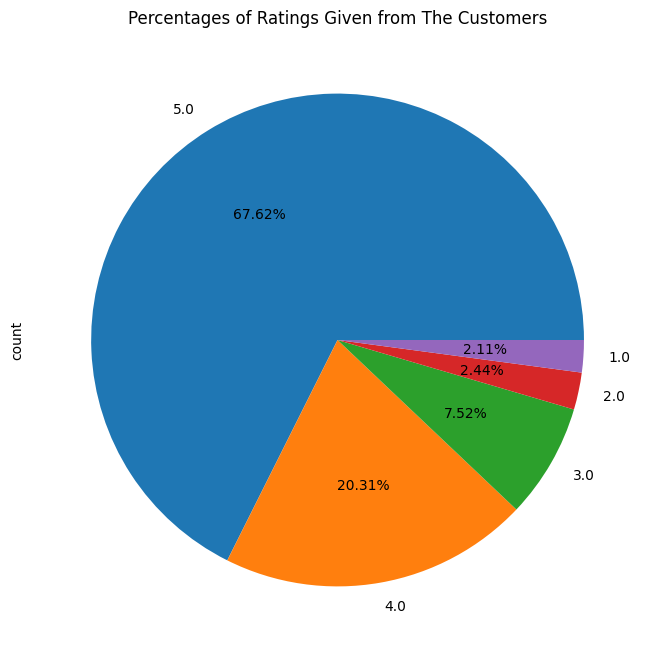

In [98]:
dataset.overall.value_counts().plot(kind = "pie", legend = False, autopct = "%1.2f%%", fontsize = 10, figsize=(8,8))
plt.title("Percentages of Ratings Given from The Customers", loc = "center")
plt.show()

From the chart above, the majority of musical instruments sold on Amazon have perfect ratings of 5.0, meaning the condition of the products are good. If we were to denote that ratings above 3 are positive, ratings equal to 3 are neutral, and ratings under 3 are negative, we know that the number of negative reviews given in the dataset are relatively small. This might affect our model later.

Creating labels : Positive , Negative and Neutral

In [99]:
def Labelling(Rows):
  if(Rows["overall"] > 3.0):
    Label = "Positive"
  elif(Rows["overall"] < 3.0):
    Label = "Negative"
  else:
    Label = "Neutral"
  return Label

In [100]:
dataset["sentiment"] = dataset.apply(Labelling, axis = 1)

In [102]:
dataset.head(2)

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014","Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing, good",Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013","The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :] Jake",Positive


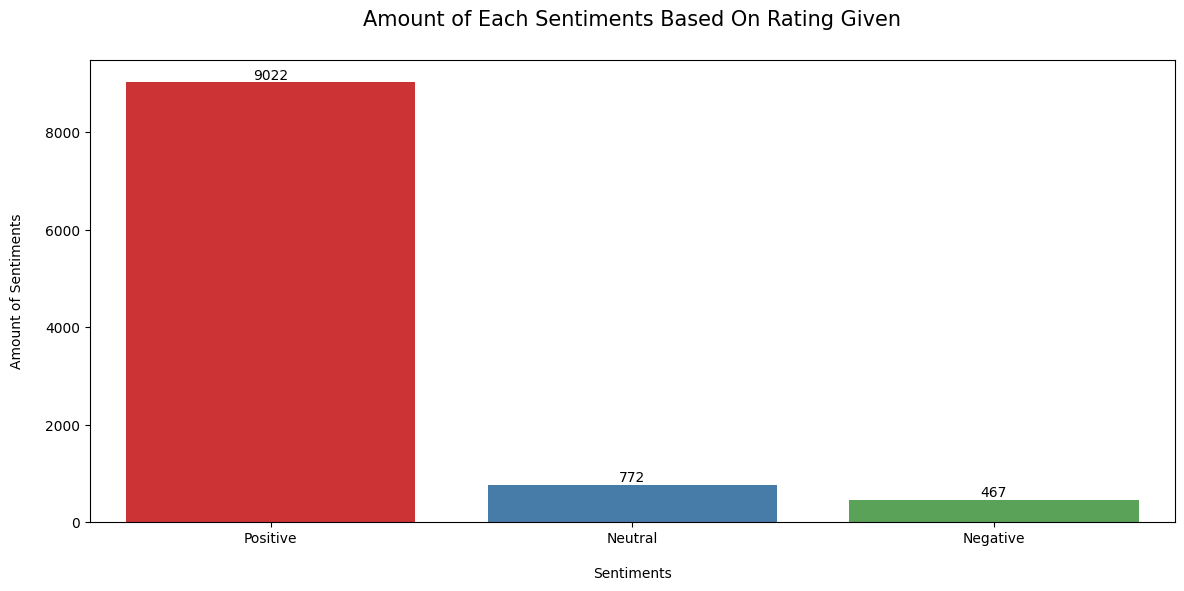

In [104]:
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.barplot(dataset["sentiment"].value_counts() , palette = 'Set1');

# Show bar values on top of the bars
for bar in plt.gca().patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, int(height), ha='center', va='bottom')  # Adjust vertical offset (0.1) as needed

plt.title("Amount of Each Sentiments Based On Rating Given", loc = "center", fontsize = 15, color = "black", pad = 25)
plt.xlabel("Sentiments", color = "black", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Amount of Sentiments", color = "black", fontsize = 10, labelpad = 15)
plt.show()

# 3. Defining the helper functions ( text preprocessing ) and executing them

a. Defining the text cleaning function

In [106]:
def Text_Cleaning(Text):
  # Lowercase the texts
  Text = Text.lower()

  # Cleaning punctuations in the text
  punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  Text = Text.translate(punc)

  # Removing numbers in the text
  Text = re.sub(r'\d+', '', Text)

  # Remove possible links
  Text = re.sub('https?://\S+|www\.\S+', '', Text)

  # Deleting newlines
  Text = re.sub('\n', '', Text)

  return Text

b. Defining the Text processing function

In [107]:
# Stopwords
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

def Text_Processing(Text):
  Processed_Text = list()
  Lemmatizer = WordNetLemmatizer()

  # Tokens of Words
  Tokens = nltk.word_tokenize(Text)

  # Removing Stopwords and Lemmatizing Words
  # To reduce noises in our dataset, also to keep it simple and still
  # powerful, we will only omit the word `not` from the list of stopwords

  for word in Tokens:
    if word not in Stopwords:
      Processed_Text.append(Lemmatizer.lemmatize(word))

  return(" ".join(Processed_Text))

In [108]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

c. Leveraging Text Cleaning and Text Processing function to clean the reviews column

In [109]:
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Cleaning(Text))
dataset["reviews"] = dataset["reviews"].apply(lambda Text: Text_Processing(Text))

In [111]:
dataset.head(5)

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014",not much write exactly supposed filter pop sound recording much crisp one lowest price pop filter amazon might well buy honestly work despite pricing good,Positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",product exactly quite affordable not realized double screened arrived even better expected added bonus one screen carry small hint smell old grape candy used buy reminiscent sake not stop putting pop filter next nose smelling recording dif needed pop filter work well expensive one may even come pleasing aroma like mine buy product jake,Positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",primary job device block breath would otherwise produce popping sound allowing voice pas noticeable reduction volume high frequency double cloth filter block pop let voice coloration metal clamp mount attache mike stand secure enough keep attached goose neck need little coaxing stay put job well,Positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",nice windscreen protects mxl mic prevents pop thing gooseneck marginally able hold screen position requires careful positioning clamp avoid sagging good windscreen money,Positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",pop filter great look performs like studio filter recording vocal eliminate pop get recorded sing pop record vocal,Positive


# 4. Detailed Exploratory Data Analysis

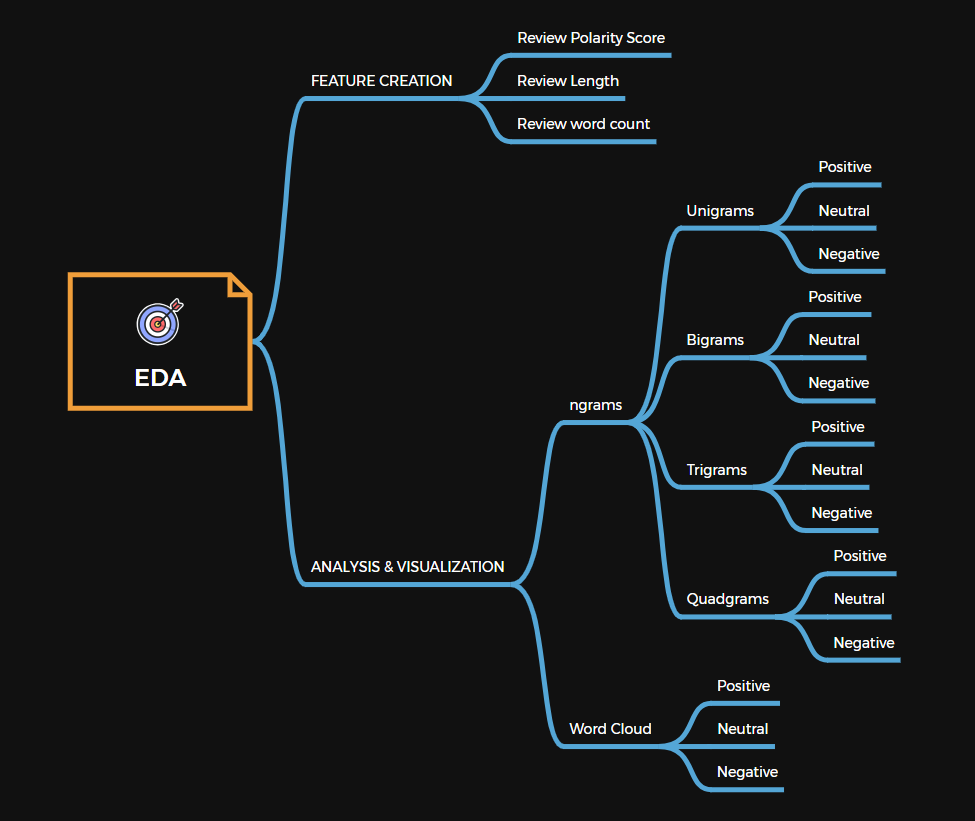

In [113]:
dataset.describe(include = "all")

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment
count,10261,10261,10234,10261,10261.000000,1.026100e+04,10261,10261,10261
unique,1429,900,1397,269,NaN,NaN,1570,10254,3
top,ADH0O8UVJOT10,B003VWJ2K8,Amazon Customer,"[0, 0]",NaN,NaN,"01 22, 2013",good string five star,Positive
freq,42,163,66,6796,NaN,NaN,40,3,9022
mean,NaN,NaN,NaN,NaN,4.488744,1.360606e+09,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.894642,3.779735e+07,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.095466e+09,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.000000,1.343434e+09,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.000000,1.368490e+09,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,1.388966e+09,NaN,NaN,NaN


a. Polarity of the data - analysis and visualization

In [114]:
dataset["polarity"] = dataset["reviews"].map(lambda Text: TextBlob(Text).sentiment.polarity)

In [115]:
dataset.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment,polarity
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014",not much write exactly supposed filter pop sound recording much crisp one lowest price pop filter amazon might well buy honestly work despite pricing good,Positive,0.3500
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",product exactly quite affordable not realized double screened arrived even better expected added bonus one screen carry small hint smell old grape candy used buy reminiscent sake not stop putting pop filter next nose smelling recording dif needed pop filter work well expensive one may even come pleasing aroma like mine buy product jake,Positive,0.0000
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",primary job device block breath would otherwise produce popping sound allowing voice pas noticeable reduction volume high frequency double cloth filter block pop let voice coloration metal clamp mount attache mike stand secure enough keep attached goose neck need little coaxing stay put job well,Positive,0.1675
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",nice windscreen protects mxl mic prevents pop thing gooseneck marginally able hold screen position requires careful positioning clamp avoid sagging good windscreen money,Positive,0.4250
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",pop filter great look performs like studio filter recording vocal eliminate pop get recorded sing pop record vocal,Positive,0.8000


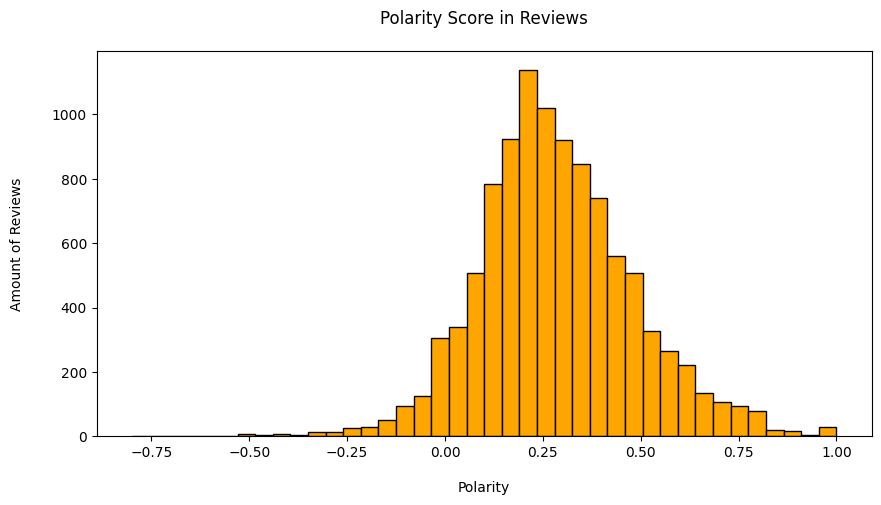

In [117]:
dataset["polarity"].plot(kind = "hist", bins = 40, edgecolor = "black", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Polarity Score in Reviews", color = "black", pad = 20)
plt.xlabel("Polarity", labelpad = 15, color = "black")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "black")

plt.show()

Reviews with negative polarity will be in range of [-1, 0), neutral ones will be 0.0, and positive reviews will have the range of (0, 1].

From the histogram above, we know that most of the reviews are distributed in positive sentiments, meaning that what we extracted from our analysis before is true. Statistically, this histogram shows that our data is normally distributed, but not with standard distribution. In conclusion, we know for sure that our analysis about the amount of sentiments from the reviews is correct and corresponds to the histogram above.

b. Length of the review - analysis and visualization

In [118]:
dataset["length"] = dataset["reviews"].astype(str).apply(len)

In [119]:
dataset.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment,polarity,length
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014",not much write exactly supposed filter pop sound recording much crisp one lowest price pop filter amazon might well buy honestly work despite pricing good,Positive,0.3500,154
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",product exactly quite affordable not realized double screened arrived even better expected added bonus one screen carry small hint smell old grape candy used buy reminiscent sake not stop putting pop filter next nose smelling recording dif needed pop filter work well expensive one may even come pleasing aroma like mine buy product jake,Positive,0.0000,337
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",primary job device block breath would otherwise produce popping sound allowing voice pas noticeable reduction volume high frequency double cloth filter block pop let voice coloration metal clamp mount attache mike stand secure enough keep attached goose neck need little coaxing stay put job well,Positive,0.1675,296
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",nice windscreen protects mxl mic prevents pop thing gooseneck marginally able hold screen position requires careful positioning clamp avoid sagging good windscreen money,Positive,0.4250,169
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",pop filter great look performs like studio filter recording vocal eliminate pop get recorded sing pop record vocal,Positive,0.8000,114


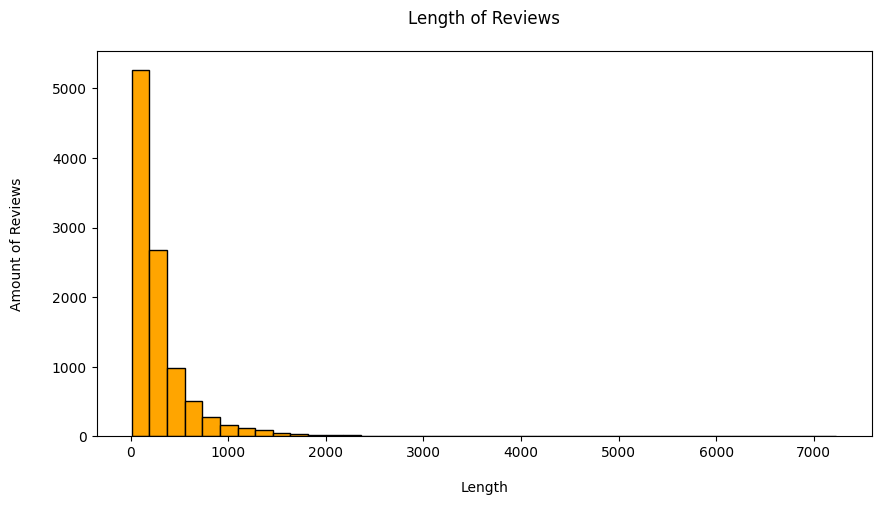

In [120]:
dataset["length"].plot(kind = "hist", bins = 40, edgecolor = "black", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Length of Reviews", color = "black", pad = 20)
plt.xlabel("Length", labelpad = 15, color = "black")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "black")

plt.show()

Based on this, we know that our review has text length between approximately 0-1000 characters. The distribution itself has positive skewness, or in other words it is skewed right, and this means that our reviews rarely has larger length than 1000 characters. Of course, the review that we use here is affected by the text preprocessing phase, so the length might not be the actual value of the review itself as some words might have been omitted already. This will also have the same effect when we count the tatal of words in our reviews.

c. Word count - analysis and visualization

In [121]:
dataset["word_counts"] = dataset["reviews"].apply(lambda x: len(str(x).split()))

In [122]:
dataset.head()

,reviewerID,asin,reviewerName,helpful,overall,unixReviewTime,reviewTime,reviews,sentiment,polarity,length,word_counts
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]",5.0,1393545600,"02 28, 2014",not much write exactly supposed filter pop sound recording much crisp one lowest price pop filter amazon might well buy honestly work despite pricing good,Positive,0.3500,154,25
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",5.0,1363392000,"03 16, 2013",product exactly quite affordable not realized double screened arrived even better expected added bonus one screen carry small hint smell old grape candy used buy reminiscent sake not stop putting pop filter next nose smelling recording dif needed pop filter work well expensive one may even come pleasing aroma like mine buy product jake,Positive,0.0000,337,54
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",5.0,1377648000,"08 28, 2013",primary job device block breath would otherwise produce popping sound allowing voice pas noticeable reduction volume high frequency double cloth filter block pop let voice coloration metal clamp mount attache mike stand secure enough keep attached goose neck need little coaxing stay put job well,Positive,0.1675,296,45
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",5.0,1392336000,"02 14, 2014",nice windscreen protects mxl mic prevents pop thing gooseneck marginally able hold screen position requires careful positioning clamp avoid sagging good windscreen money,Positive,0.4250,169,23
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",5.0,1392940800,"02 21, 2014",pop filter great look performs like studio filter recording vocal eliminate pop get recorded sing pop record vocal,Positive,0.8000,114,18


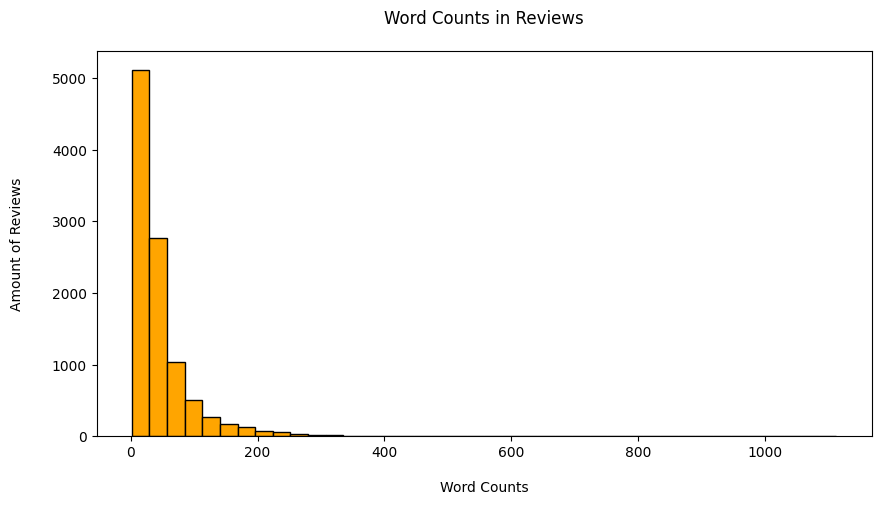

In [123]:
dataset["word_counts"].plot(kind = "hist", bins = 40, edgecolor = "black", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Word Counts in Reviews", color = "black", pad = 20)
plt.xlabel("Word Counts", labelpad = 15, color = "black")
plt.ylabel("Amount of Reviews", labelpad = 20, color = "black")

plt.show()

d. Defining the n-gram Helper function

In [124]:
def Gram_Analysis(Corpus, Gram, N):
  # Vectorizer
  # Convert Stopwords to a list
  Vectorizer = CountVectorizer(stop_words = list(Stopwords), ngram_range=(Gram,Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key = lambda x:x[1], reverse = True)

  return words[:N]

In [126]:
# Use dropna() so the base DataFrame is not affected

Positive = dataset[dataset["sentiment"] == "Positive"].dropna()
Neutral = dataset[dataset["sentiment"] == "Neutral"].dropna()
Negative = dataset[dataset["sentiment"] == "Negative"].dropna()

In [130]:
Positive.sentiment.value_counts() , Neutral.sentiment.value_counts() , Negative.sentiment.value_counts()

(sentiment
 Positive    8998
 Name: count, dtype: int64,
 sentiment
 Neutral    771
 Name: count, dtype: int64,
 sentiment
 Negative    465
 Name: count, dtype: int64)

e. Analyzing Unigrams and visualizing them for all the Dataframes ( Positive , Neutral , Negative )

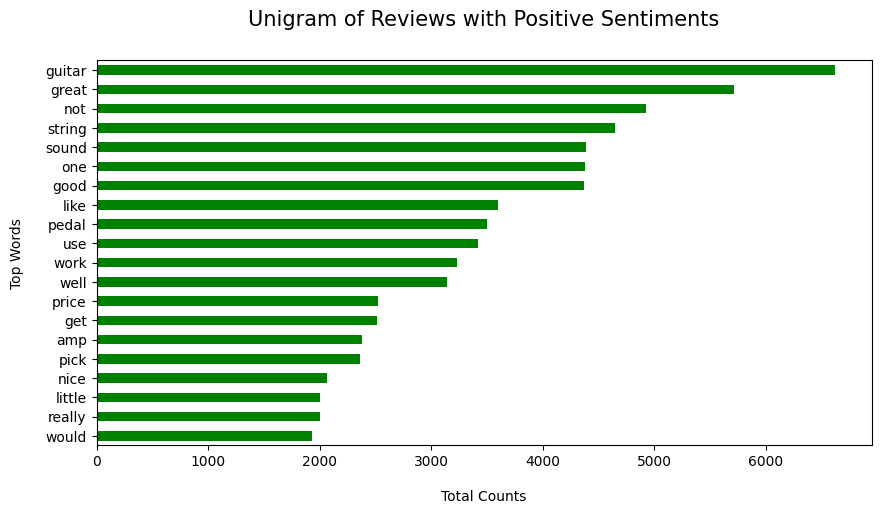

In [131]:
# Finding Unigram
words = Gram_Analysis(Positive["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Unigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "black", pad = 25)
plt.xlabel("Total Counts", color = "black", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "black", fontsize = 10, labelpad = 15)
plt.show()

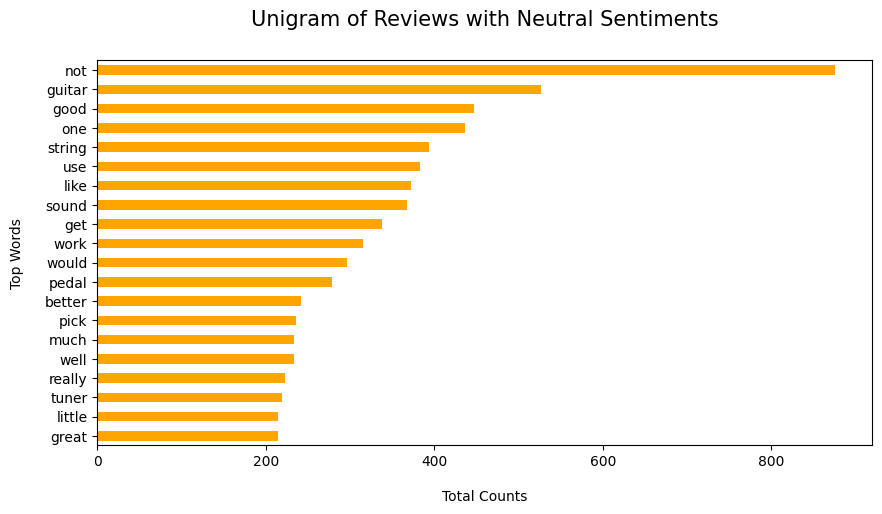

In [132]:
# Finding Unigram
words = Gram_Analysis(Neutral["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Unigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "black", pad = 25)
plt.xlabel("Total Counts", color = "black", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "black", fontsize = 10, labelpad = 15)
plt.show()

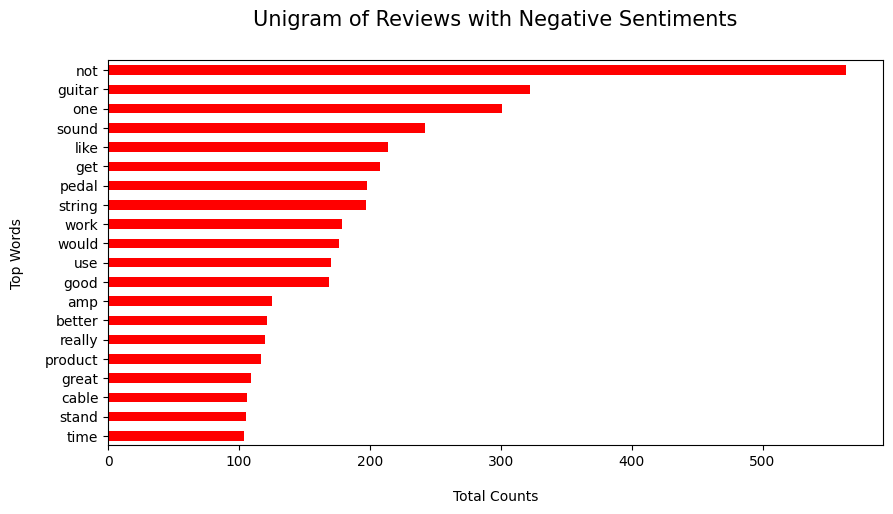

In [133]:
# Finding Unigram
words = Gram_Analysis(Negative["reviews"], 1, 20)
Unigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Unigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "black", pad = 25)
plt.xlabel("Total Counts", color = "black", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "black", fontsize = 10, labelpad = 15)
plt.show()

f. Analyzing Bigrams and visualizing them for all the Dataframes ( Positive , Neutral , Negative )

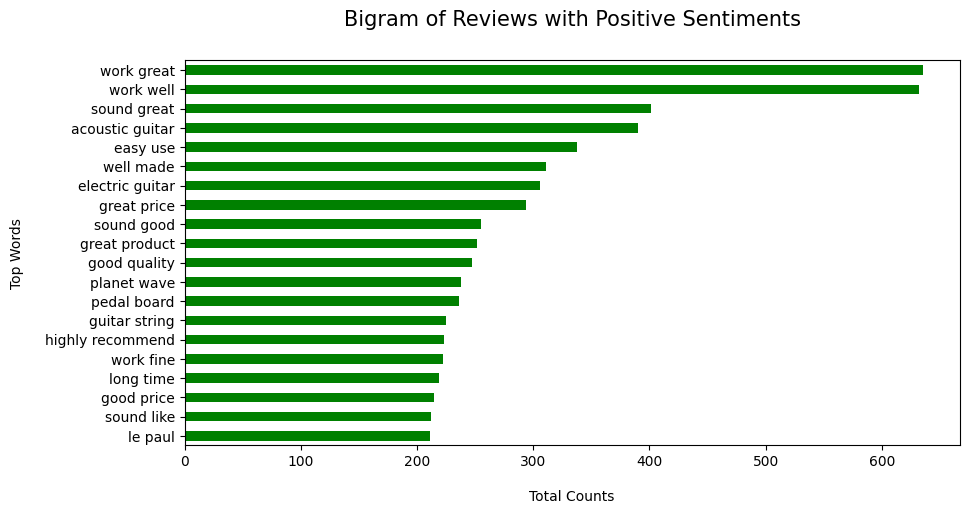

In [134]:
# Finding Bigram
words = Gram_Analysis(Positive["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Bigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "black", pad = 25)
plt.xlabel("Total Counts", color = "black", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "black", fontsize = 10, labelpad = 15)
plt.show()

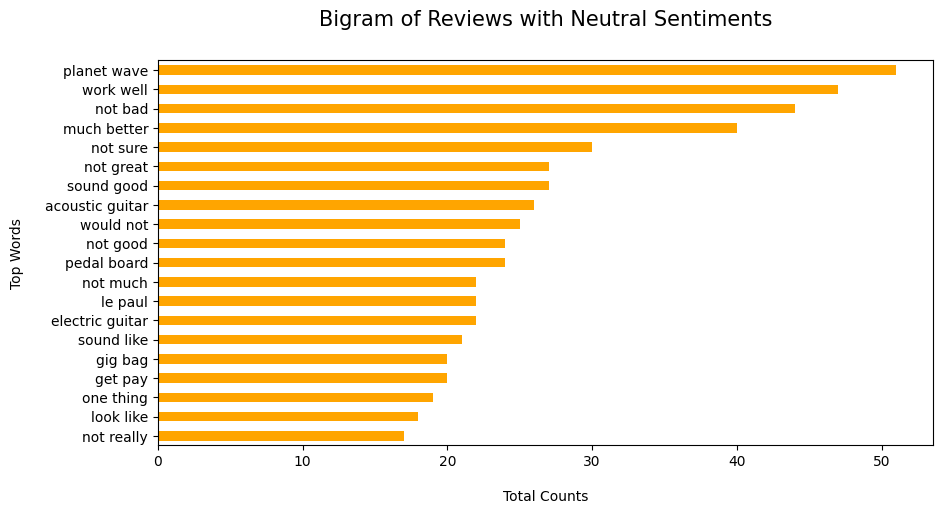

In [135]:
# Finding Bigram
words = Gram_Analysis(Neutral["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Bigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "black", pad = 25)
plt.xlabel("Total Counts", color = "black", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "black", fontsize = 10, labelpad = 15)
plt.show()

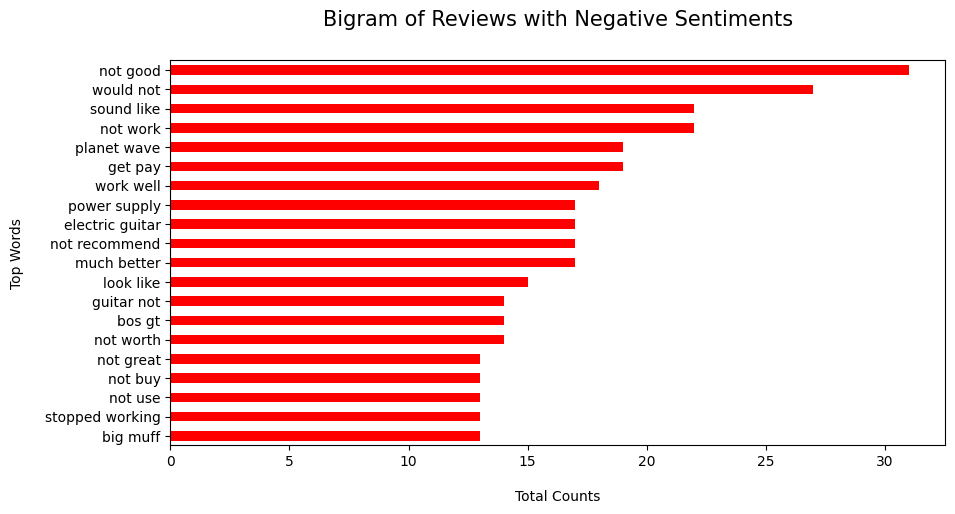

In [136]:
# Finding Bigram
words = Gram_Analysis(Negative["reviews"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Bigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "black", pad = 25)
plt.xlabel("Total Counts", color = "black", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "black", fontsize = 10, labelpad = 15)
plt.show()

g. Analyzing Trigrams and visualizing them for all the Dataframes ( Positive , Neutral , Negative )

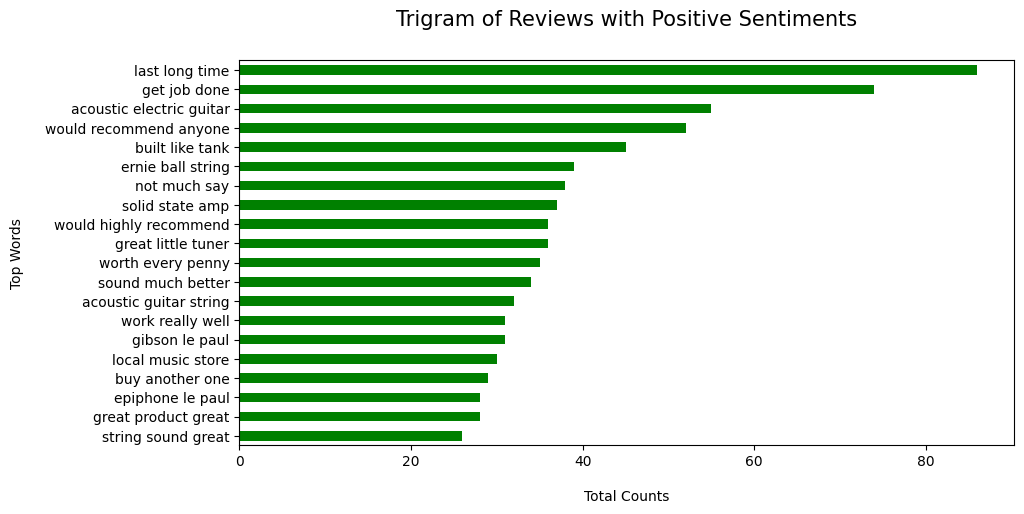

In [137]:
# Finding Trigram
words = Gram_Analysis(Positive["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Trigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "black", pad = 25)
plt.xlabel("Total Counts", color = "black", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "black", fontsize = 10, labelpad = 15)
plt.show()

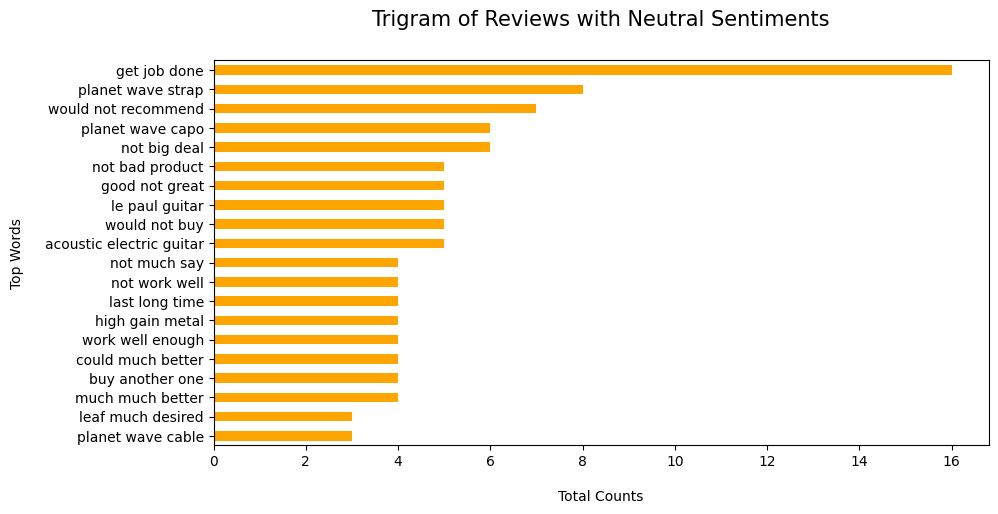

In [138]:
# Finding Trigram
words = Gram_Analysis(Neutral["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Trigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "black", pad = 25)
plt.xlabel("Total Counts", color = "black", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "black", fontsize = 10, labelpad = 15)
plt.show()

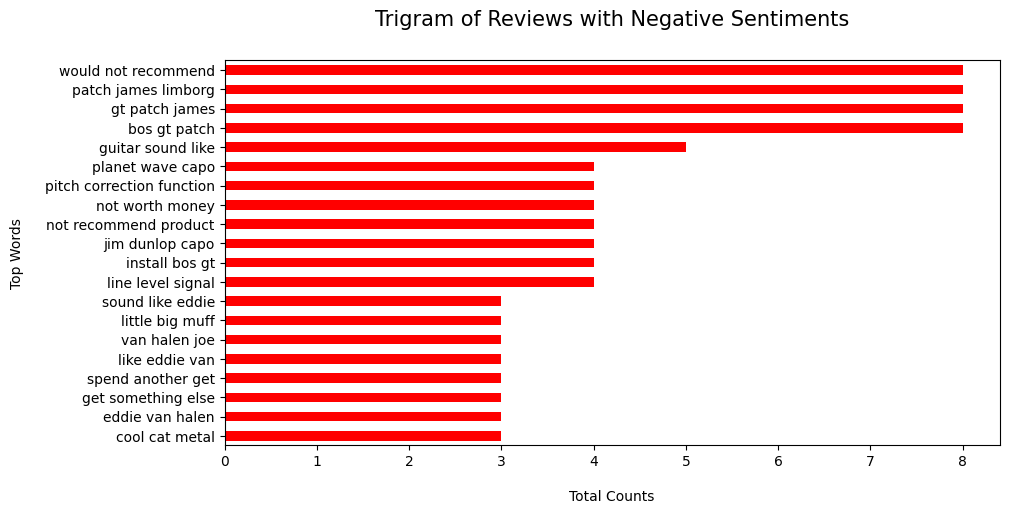

In [139]:
# Finding Trigram
words = Gram_Analysis(Negative["reviews"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Trigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "black", pad = 25)
plt.xlabel("Total Counts", color = "black", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "black", fontsize = 10, labelpad = 15)
plt.show()

h. Analyzing Quadgrams and visualizing them for all the Dataframes ( Positive , Neutral , Negative )

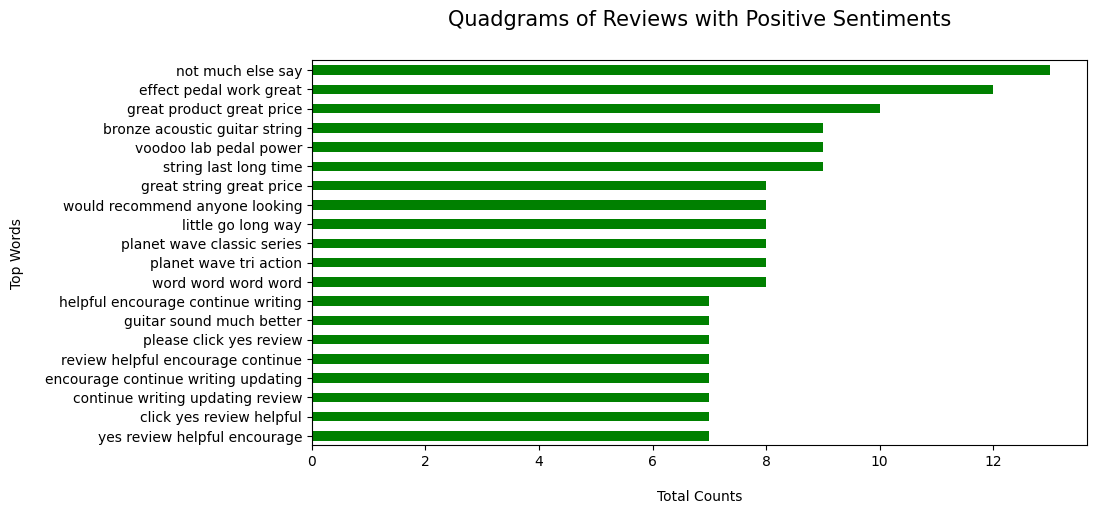

In [140]:
# Finding Quadgrams
words = Gram_Analysis(Positive["reviews"], 4, 20)
Quadgrams = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Quadgrams.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Quadgrams of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "black", pad = 25)
plt.xlabel("Total Counts", color = "black", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "black", fontsize = 10, labelpad = 15)
plt.show()

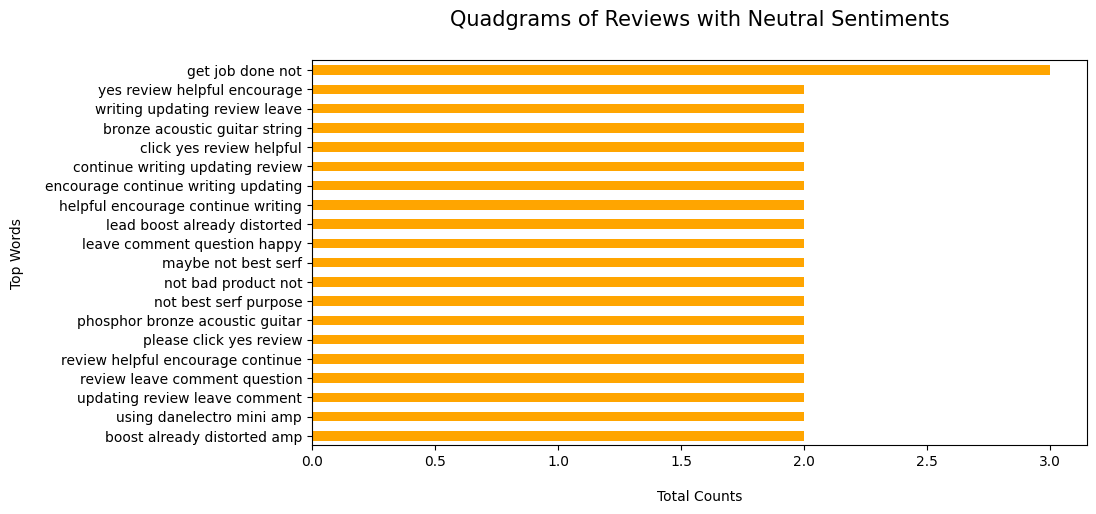

In [142]:
# Finding Quadgrams
words = Gram_Analysis(Neutral["reviews"], 4, 20)
Quadgrams = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Quadgrams.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Quadgrams of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "black", pad = 25)
plt.xlabel("Total Counts", color = "black", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "black", fontsize = 10, labelpad = 15)
plt.show()

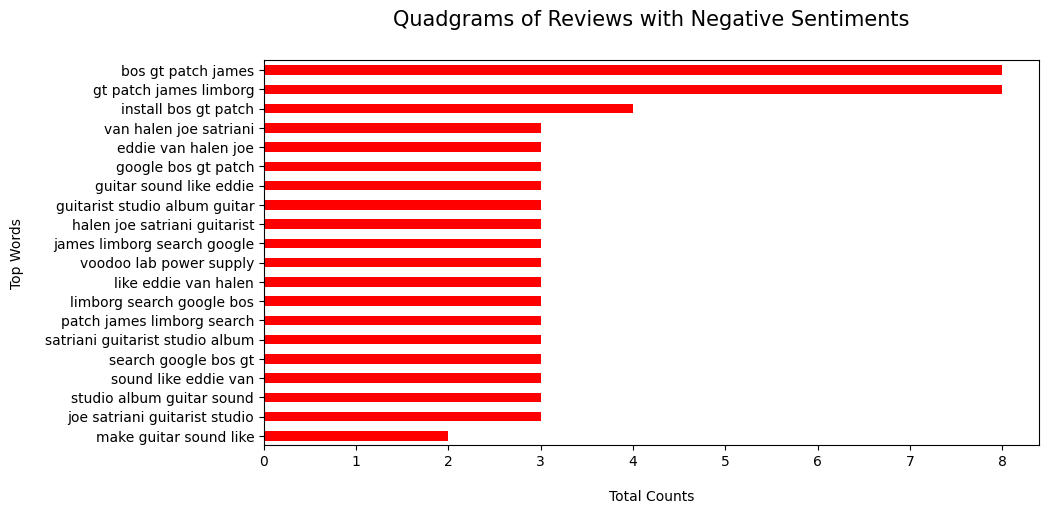

In [143]:
# Finding Quadgrams
words = Gram_Analysis(Negative["reviews"], 4, 20)
Quadgrams = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Quadgrams.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Quadgrams of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "black", pad = 25)
plt.xlabel("Total Counts", color = "black", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "black", fontsize = 10, labelpad = 15)
plt.show()

I. Wordcloud visualization for  reviews

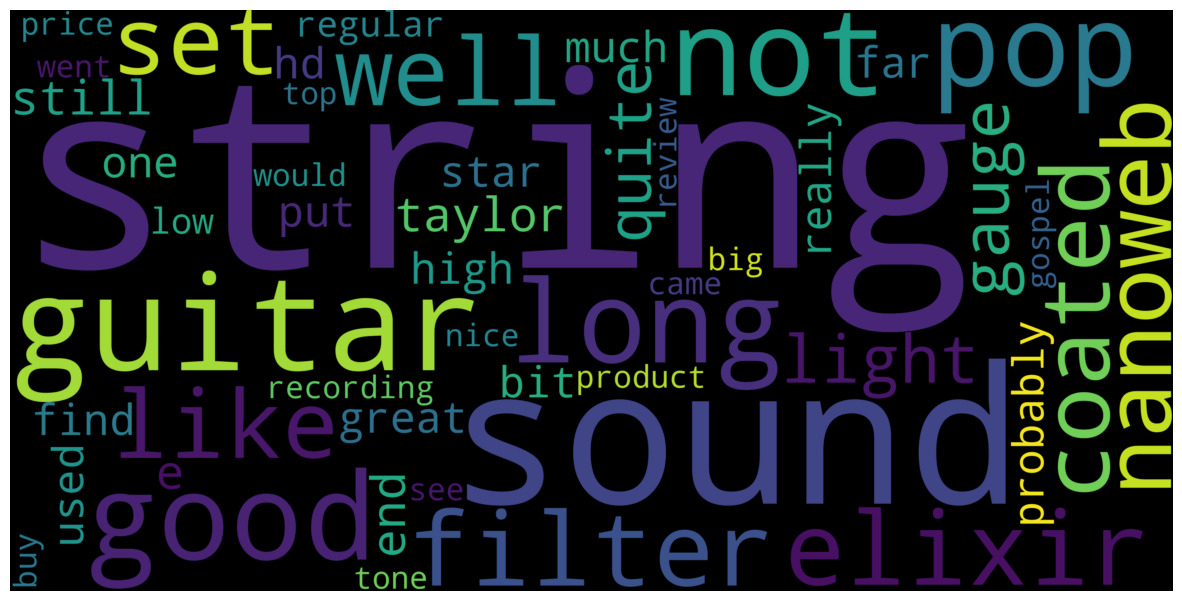

In [145]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Positive["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

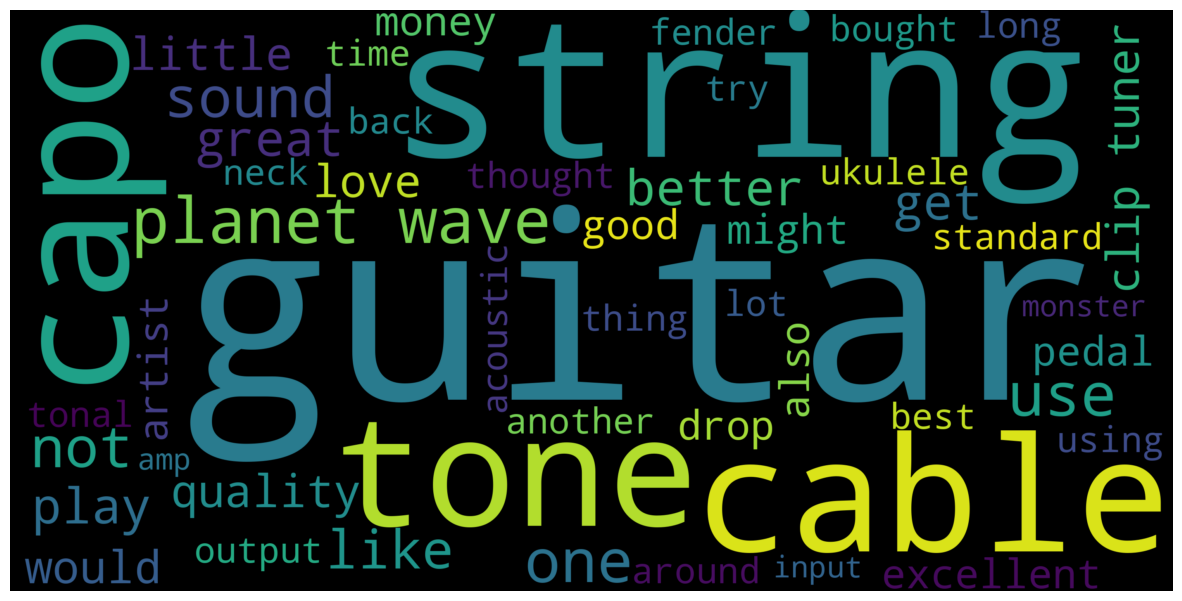

In [146]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Neutral["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

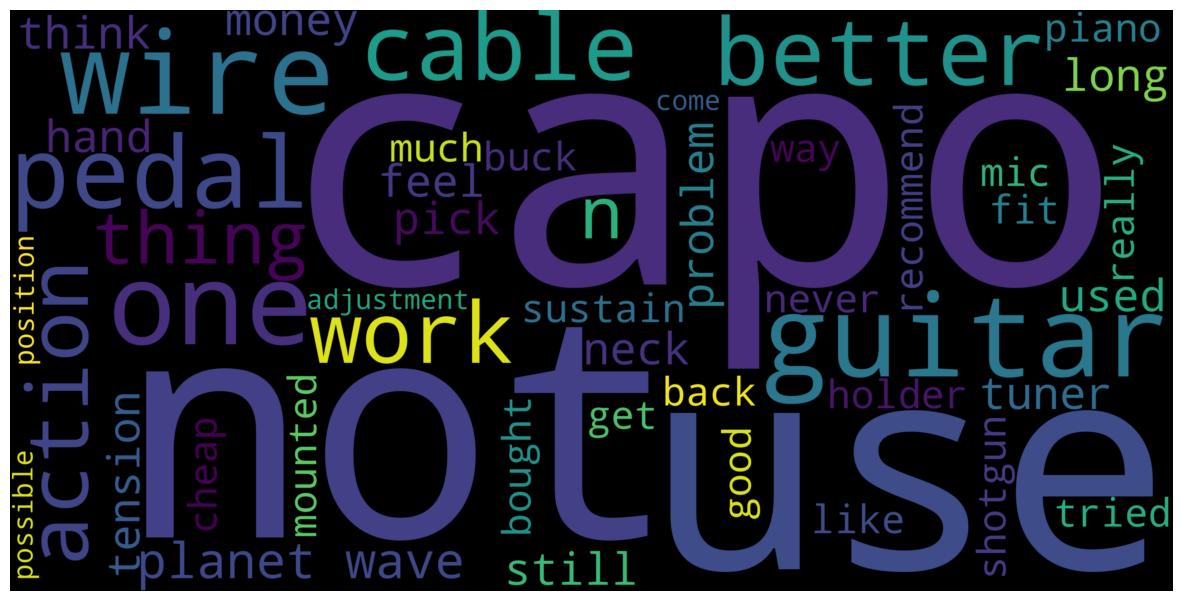

In [147]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Negative["reviews"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

j. Dropping unnecessary columns

In [148]:
Columns = ["reviewerID", "asin", "reviewerName", "helpful", "unixReviewTime", "reviewTime", "polarity", "length", "word_counts", "overall"]
dataset.drop(columns = Columns, axis = 1, inplace = True)

In [149]:
dataset.head()

,reviews,sentiment
0,not much write exactly supposed filter pop sound recording much crisp one lowest price pop filter amazon might well buy honestly work despite pricing good,Positive
1,product exactly quite affordable not realized double screened arrived even better expected added bonus one screen carry small hint smell old grape candy used buy reminiscent sake not stop putting pop filter next nose smelling recording dif needed pop filter work well expensive one may even come pleasing aroma like mine buy product jake,Positive
2,primary job device block breath would otherwise produce popping sound allowing voice pas noticeable reduction volume high frequency double cloth filter block pop let voice coloration metal clamp mount attache mike stand secure enough keep attached goose neck need little coaxing stay put job well,Positive
3,nice windscreen protects mxl mic prevents pop thing gooseneck marginally able hold screen position requires careful positioning clamp avoid sagging good windscreen money,Positive
4,pop filter great look performs like studio filter recording vocal eliminate pop get recorded sing pop record vocal,Positive


k. Label Encoding the prediction column

In [150]:
Encoder = LabelEncoder()
dataset["sentiment"] = Encoder.fit_transform(dataset["sentiment"])

In [151]:
dataset["sentiment"].value_counts()

,count
sentiment,
2,9022
1,772
0,467


L. Vectorize the reviews column using TFidf Vectorizer

In [152]:
# Defining our vectorizer with total words of 5000 and with bigram model
TF_IDF = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))

# Fitting and transforming our reviews into a matrix of weighed words
# This will be our independent features
X = TF_IDF.fit_transform(dataset["reviews"])

# Check our matrix shape
X.shape

(10261, 5000)

In [153]:
# Declaring our target variable

y = dataset["sentiment"]

In [154]:
Counter(y)

Counter({2: 9022, 1: 772, 0: 467})

m. Balancing the dataset using SMOTE as positive reviews are around 88% of the data

In [155]:
Balancer = SMOTE(random_state = 42)
X_final, y_final = Balancer.fit_resample(X, y)

In [156]:
Counter(y_final)

Counter({2: 9022, 1: 9022, 0: 9022})

# 5. Model Selection , Optimization and Evaluation

Train test split

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.25, random_state = 42)

Baseline model declaration and execution to find out the best performing algorithm

In [158]:
DTree = DecisionTreeClassifier()
LogReg = LogisticRegression()
SVC = SVC()
RForest = RandomForestClassifier()
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

Models = [DTree, LogReg, SVC, RForest, Bayes, KNN]
Models_Dict = {0: "Decision Tree", 1: "Logistic Regression", 2: "SVC", 3: "Random Forest", 4: "Naive Bayes", 5: "K-Neighbors"}

for i, model in enumerate(Models):
  print("{} Test Accuracy: {}".format(Models_Dict[i], cross_val_score(model, X, y, cv = 10, scoring = "accuracy").mean()))

Decision Tree Test Accuracy: 0.820485393403448
Logistic Regression Test Accuracy: 0.8819802942387887
SVC Test Accuracy: 0.8805184008381876
Random Forest Test Accuracy: 0.876912542635394
Naive Bayes Test Accuracy: 0.8099589827104816
K-Neighbors Test Accuracy: 0.8476764777897356


We got six models on our sleeves and from the results of 10-Fold Cross Validation, we know that the Logistic Regression model is the best model with the highest accuracy, slightly beating the SVC. Because of this, we will use the best model in predicting our sentiment, also to tune our parameter and evaluate the end-result of how well the model works.

Hyperparameter optimization using GridSearchCV for Logistic regression algorithm

In [159]:
Param = {"C": np.logspace(-4, 4, 50), "penalty": ['l1', 'l2']}
grid_search = GridSearchCV(estimator = LogisticRegression(random_state = 42), param_grid = Param, scoring = "accuracy", cv = 10, verbose = 0, n_jobs = -1)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 94.75 %
Best Parameters: {'C': 10000.0, 'penalty': 'l2'}


We got a nice accuracy on our training set, which is 94.75% and from our Grid Search, we are also able to find our optimal hyperparameters. It is time to finish our model using these parameters to get the best model of Logistic Regression.

In [160]:
Classifier = LogisticRegression(random_state = 42, C = 10000.0, penalty = 'l2')
Classifier.fit(X_train, y_train)

Prediction = Classifier.predict(X_test)

In [161]:
accuracy_score(y_test, Prediction)

0.9541894487956258

In [162]:
ConfusionMatrix = confusion_matrix(y_test, Prediction)

In [167]:
# Plotting Function for Confusion Matrix

def plot_cm(cm, classes, title, normalized = False, cmap = plt.cm.Blues):

  plt.imshow(cm, interpolation = "nearest", cmap = cmap)
  plt.title(title, pad = 20)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  if normalized:
    cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Unnormalized Confusion Matrix")

  threshold = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

  plt.tight_layout()
  plt.xlabel("Predicted Label", labelpad = 20)
  plt.ylabel("Real Label", labelpad = 20)

Unnormalized Confusion Matrix


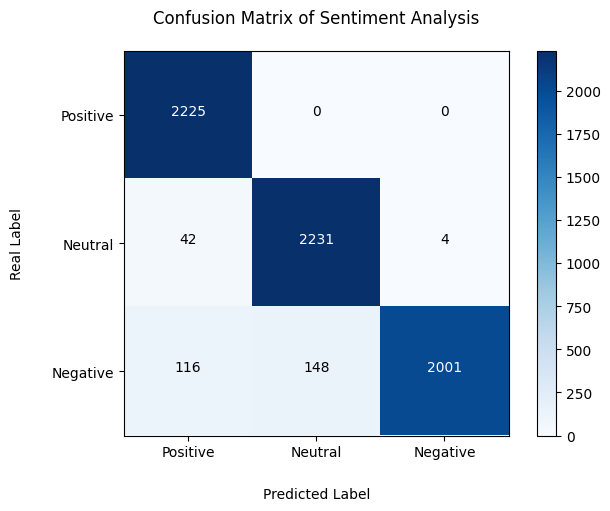

In [163]:
plot_cm(ConfusionMatrix, classes = ["Positive", "Neutral", "Negative"], title = "Confusion Matrix of Sentiment Analysis")

In [164]:
print(classification_report(y_test, Prediction))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      2225
           1       0.94      0.98      0.96      2277
           2       1.00      0.88      0.94      2265

    accuracy                           0.95      6767
   macro avg       0.96      0.95      0.95      6767
weighted avg       0.96      0.95      0.95      6767

